# Image Inference

***
### Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
import os
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import cv2 

***

### Class definition
Here we define the class using nn.Module instead of pl.LightningModule that we used to train the neuronal network.

In [2]:
class FractureModel(nn.Module):
    def __init__(self, weight=1):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        self.loss = torch.nn.BCEWithLogitsLoss(torch.tensor([weight]))
    def forward(self, data):
        pred = self.model(data)
        return pred

***

### Creation of an instance of the model

In [3]:
model = FractureModel()

***

### Loading trained model and defining the transforms

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load("D:/UltrasoundAI/UltrasoundAI/FractureClassification/Resources/Model/ResNet18 Transfer Learning/checkpoints/best_model_epoch=91.pth")
print(checkpoint.keys())
model.load_state_dict(checkpoint['state_dict'])
model.eval();
print(device)
model.to(device);

dict_keys(['state_dict'])
cuda:0


In [5]:
val_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(0.12967301527195704, 0.11952487479741893)
])

***

### Inference

Here I try to do the same as it is made in the training notebook, in order to see if the model can be used without any compatibility problem.

In [6]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [7]:
# Se define el dataset.
val_dataset = torchvision.datasets.DatasetFolder("D:/FractureUltrasoundSimulator/FractureUltrasoundSimulator/Resources/Data/Dataset_Fantoma/Processed/val", 
                                                   loader=load_file, extensions="npy", transform=val_transforms)

# Variables que van a ser rellenadas dentro del bucle for.
preds = []
labels = []
names = []
# Contador.
i = 0
for data, label in tqdm(val_dataset):
    data = data.to(device).float().unsqueeze(0) # Se adecua el dato indexado para pasarlo por el modelo.
    pred = torch.sigmoid(model(data)) # Predicción dada por el modelo.
    preds.append(pred) # Se llena el array vacío preds.
    labels.append(label) # Se llena el array vacío label.
    filename = os.path.basename(val_dataset.samples[i][0]) + " " + "pos. array = " + str(i) #Se obtiene el nombre del archivo
                                                                                        # del cual se ha hecho una predicción.
    names.append(filename) # Se llena el array names con los nombres de los archivos sujetos a predicción.
    i+=1 # Se incrementa el contador.

# Se convierten los arrays en tensores.
preds = torch.tensor(preds) 
labels = torch.tensor(labels).int() 

  0%|          | 0/32 [00:00<?, ?it/s]

In [8]:
preds

tensor([0.0373, 0.0450, 0.3689, 0.0068, 0.4292, 0.8360, 0.0084, 0.0091, 0.5136,
        0.0047, 0.0166, 0.2871, 0.0070, 0.0057, 0.0132, 0.0126, 0.9818, 0.9998,
        0.4244, 0.7864, 0.9944, 0.9412, 0.9938, 0.1569, 0.7903, 0.5103, 0.9307,
        0.9725, 1.0000, 0.9889, 0.9791, 0.8209])

In [9]:
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.int32)

In [10]:
names

['Healthy48.npy pos. array = 0',
 'Healthy49.npy pos. array = 1',
 'Healthy50.npy pos. array = 2',
 'Healthy51.npy pos. array = 3',
 'Healthy52.npy pos. array = 4',
 'Healthy53.npy pos. array = 5',
 'Healthy54.npy pos. array = 6',
 'Healthy55.npy pos. array = 7',
 'Healthy56.npy pos. array = 8',
 'Healthy57.npy pos. array = 9',
 'Healthy58.npy pos. array = 10',
 'Healthy59.npy pos. array = 11',
 'Healthy60.npy pos. array = 12',
 'Healthy61.npy pos. array = 13',
 'Healthy62.npy pos. array = 14',
 'Healthy63.npy pos. array = 15',
 'Fracture48.npy pos. array = 16',
 'Fracture49.npy pos. array = 17',
 'Fracture50.npy pos. array = 18',
 'Fracture51.npy pos. array = 19',
 'Fracture52.npy pos. array = 20',
 'Fracture53.npy pos. array = 21',
 'Fracture54.npy pos. array = 22',
 'Fracture55.npy pos. array = 23',
 'Fracture56.npy pos. array = 24',
 'Fracture57.npy pos. array = 25',
 'Fracture58.npy pos. array = 26',
 'Fracture59.npy pos. array = 27',
 'Fracture60.npy pos. array = 28',
 'Fracture6

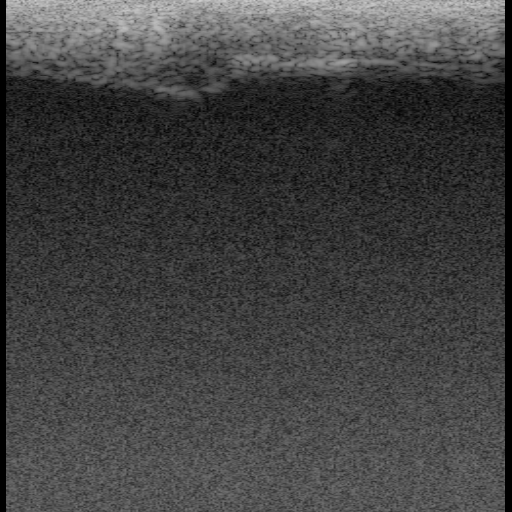

In [11]:
img1 = Image.open("D:/FractureUltrasoundSimulator/FractureUltrasoundSimulator/Resources/Data/Dataset_Fantoma/Fracture/Fracture63.png")
img1

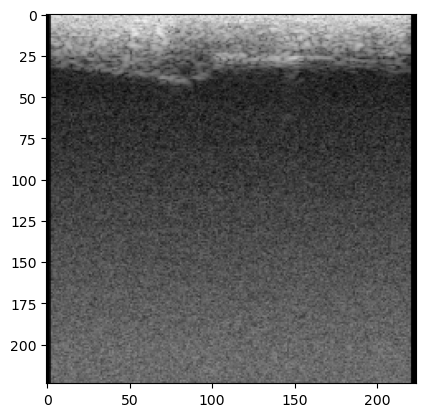

In [12]:
img_np = np.asarray(img1)/255 # Se convierte la imagen de Pillow a un array de Numpy y se normaliza.
img_array = cv2.resize(img_np, (224, 224)).astype(np.float16) 
plt.imshow(img_array, cmap='gray')
mean = np.mean(img_array)
std = np.std(img_array)

In [13]:
val_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(0.12967301527195704, 0.11952487479741893)
])

In [14]:
img_t2 = val_transforms(img_array).to(device).unsqueeze(0).float() # Se le aplican las transformaciones previas.

In [15]:
pred_img_t2 = torch.sigmoid(model(img_t2)) # Se pasa la imagen al modelo, y se guarda su predicción.

In [16]:
round(pred_img_t2.item()*100, 4) # Se muestra la predicción

82.0973

In [17]:
preds[31] * 100 # Se muestra la predicción que se guardón en el array "preds", correspondiente al archivo que se ha utilizado
                # para esta comprobación. Como se puede ver obtenemos el mismo resultado :) 

tensor(82.0927)

***
### Activation Map Creation

In [18]:
class FractureModelMap(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])    
        print(self.feature_map)
        
    def forward(self, data):
        
        feature_map = self.feature_map(data)
        return feature_map

In [19]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
temp_model = FractureModelMap()

Sequential(
  (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [21]:
temp_model.load_state_dict(checkpoint['state_dict'], strict = False)
temp_model.eval();
temp_model.to(device);

In [22]:
def heatmap_creation(model, img):
    with torch.no_grad(): # Deshabilita el cálculo del gradiente de la red neuronal. Se hace para ahorrar memoria 
                          # y acelerar el cálculo.
        features = model(img.unsqueeze(0))
    features = features.reshape((512, 49))
    weight_params = list(model.model.fc.parameters())[0] # Otención de la matriz de pesos weight_params de la capa fc.  
    weight = weight_params[0].detach() # Extrae la matriz de pesos weight de la variable weight_params y 
                                       # la separa del grafo de cálculo con el método detach().
    mult = torch.matmul(weight, features) # Multiplicación de matriz entre la matriz de pesos weight 
                                         # y las características features.
    heatmap_img = mult.reshape(7, 7).cpu()
    return heatmap_img

In [59]:
def visualize(img, heatmap):
    img = img[0]
    max = heatmap.max()
    heatmap = transforms.functional.resize(heatmap.unsqueeze(0), (224, 224))[0]
    segmentationMask = np.logical_and(heatmap[:,:] >= max*0.65, heatmap[:,:] <= max)
    print(heatmap)
    
    fig, axis = plt.subplots(1, 3, figsize=(12, 12))
    axis[0].imshow(img.cpu(), cmap="gray")
    axis[1].imshow(img.cpu(), cmap="gray")
    axis[1].imshow(heatmap, alpha=0.3, cmap="jet")
    axis[2].imshow(img.cpu(), cmap="gray")
    axis[2].imshow(segmentationMask, alpha=0.3, cmap="bone")
    plt.show()

In [60]:
print(img_t2.squeeze(1).shape)
activation_map = heatmap_creation(temp_model, img_t2.squeeze(1))

torch.Size([1, 224, 224])
torch.Size([1, 512, 7, 7])
torch.Size([512, 49])
torch.Size([1, 512])
torch.Size([512])
torch.Size([49])
tensor([[ 0.3696,  3.4756,  4.0080,  3.8974,  1.7360,  0.2057, -0.4912],
        [ 1.4894,  9.7469, 20.2285, 20.0796,  6.9057,  3.5413,  0.8656],
        [ 1.6090,  8.9182, 16.4702, 16.2972,  7.4023,  1.8744, -0.2313],
        [ 0.6488,  1.0186,  2.6714,  2.9344,  0.1799, -2.7336, -4.0444],
        [-0.6958, -1.1342, -2.0450, -1.6808, -1.5053, -2.2274, -2.3264],
        [-2.4830, -3.8985, -2.8136, -1.7126, -1.1977, -1.7212, -1.3982],
        [-3.1352, -5.1115, -4.5258, -3.7831, -3.4480, -3.6835, -2.4857]])


tensor([[ 0.3696,  0.3696,  0.3696,  ..., -0.4912, -0.4912, -0.4912],
        [ 0.3696,  0.3696,  0.3696,  ..., -0.4912, -0.4912, -0.4912],
        [ 0.3696,  0.3696,  0.3696,  ..., -0.4912, -0.4912, -0.4912],
        ...,
        [-3.1352, -3.1352, -3.1352,  ..., -2.4857, -2.4857, -2.4857],
        [-3.1352, -3.1352, -3.1352,  ..., -2.4857, -2.4857, -2.4857],
        [-3.1352, -3.1352, -3.1352,  ..., -2.4857, -2.4857, -2.4857]])


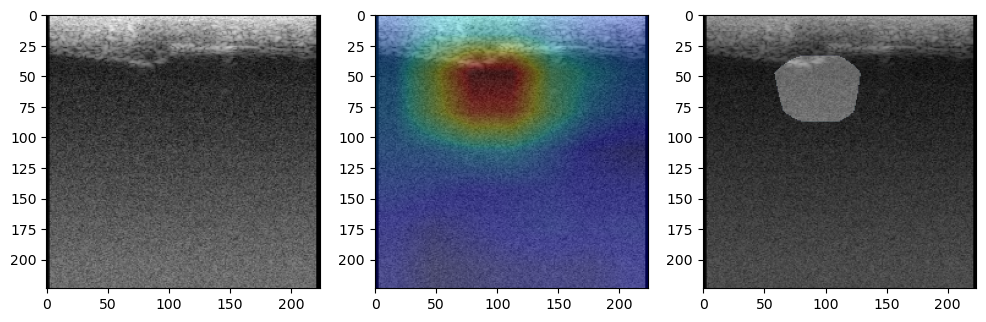

In [61]:
visualize(img_t2.squeeze(1), activation_map)